In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
%matplotlib inline
import matplotlib.gridspec as gridspec
import seaborn as sns
import warnings
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow import keras

# Visualizar datos

In [3]:
df_1 = pd.read_csv(r'train_diplo.csv')
# df_1 = df_1.drop("ID", axis=1)
# df_1['y'].replace({"yes": 1, "no": 0}, inplace=True)

FileNotFoundError: [Errno 2] No such file or directory: 'train_diplo.csv'

In [ ]:
df_1.replace("unknown", np.nan, inplace = True)

In [ ]:
df_1.info()

In [47]:
df_1.isnull().sum()

age              0
job             80
marital          0
education      547
default          0
balance          0
housing          0
loan             0
contact       3239
day              0
month            0
campaign         0
pdays            0
previous         0
poutcome     10070
y                0
dtype: int64

In [48]:
df_1['y'].value_counts()

0    8903
1    3967
Name: y, dtype: int64

In [49]:
columnas_traducidas = ["Edad", "Ocupación", "Estado civil", "Educación", "Incumplimiento de pago", "Saldo", "Préstamo vivienda", "Préstamo personal", "Método contacto", "Día", "Mes", "Campaña", "Días último contacto", "Contactos previos", "Resultado anterior", "Etiqueta"]
df_1.columns = columnas_traducidas

# Valores faltantes

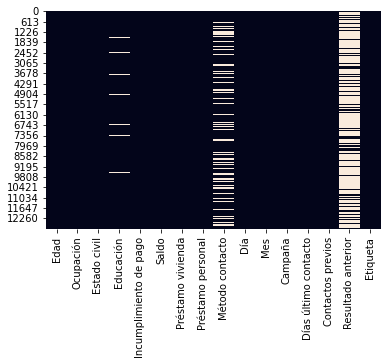

In [50]:
sns.heatmap(df_1.isnull(), cbar=False)
plt.show()

In [54]:
df = df_1

In [55]:
df = df.drop("Resultado anterior", axis=1)

In [56]:
df = df.dropna(subset=['Ocupación'], how='any')

In [57]:
moda_Educación = df['Educación'].mode()[0]
moda_Método_contacto = df['Método contacto'].mode()[0]

# Reemplaza los NaN con la moda correspondiente en cada columna
df['Educación'].fillna(moda_Educación, inplace=True)
df['Método contacto'].fillna(moda_Método_contacto, inplace=True)

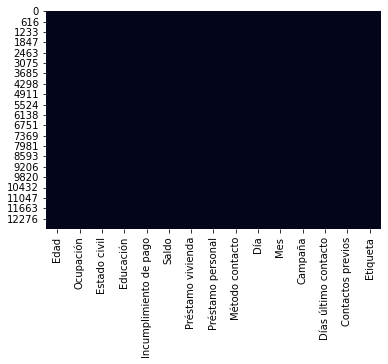

In [58]:
sns.heatmap(df.isnull(), cbar=False)
plt.show()

In [85]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12790 entries, 0 to 12869
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Edad                    12790 non-null  int64 
 1   Ocupación               12790 non-null  object
 2   Estado civil            12790 non-null  object
 3   Educación               12790 non-null  object
 4   Incumplimiento de pago  12790 non-null  object
 5   Saldo                   12790 non-null  int64 
 6   Préstamo vivienda       12790 non-null  object
 7   Préstamo personal       12790 non-null  object
 8   Método contacto         12790 non-null  object
 9   Día                     12790 non-null  int64 
 10  Mes                     12790 non-null  object
 11  Campaña                 12790 non-null  int64 
 12  Días último contacto    12790 non-null  int64 
 13  Contactos previos       12790 non-null  int64 
 14  Etiqueta                12790 non-null  int64 
dtypes:

# Graficos

In [59]:
# DataFrame con datos categóricos
df_categoricos = df.select_dtypes(include=['object']).copy()
# DataFrame con datos numéricos
df_numericos = df.select_dtypes(exclude=['object']).copy()


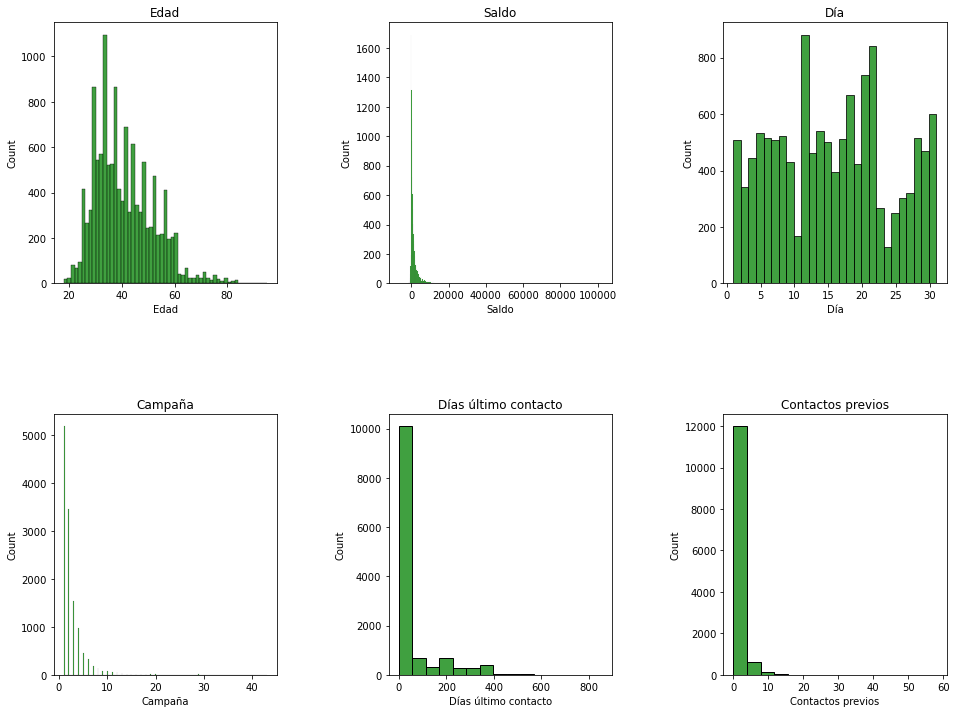

In [69]:
fig, ax = plt.subplots(2, 3, figsize=(16, 12))
plt.subplots_adjust(wspace=0.5, hspace=0.5)

for i, variable in enumerate(df_numericos):
    if i < 2 * 3:
        sns.histplot(data=df_numericos, x=variable, ax=ax[i//3, i%3], color="green")
        ax[i//3, i%3].set_title(variable)

plt.show()

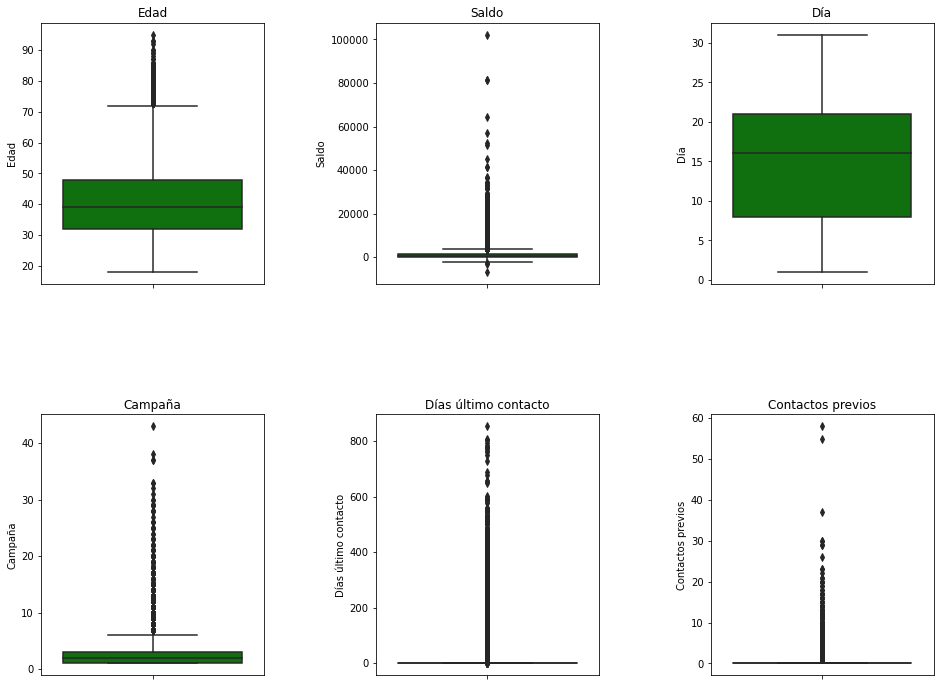

In [66]:
fig, ax = plt.subplots(2, 3, figsize=(16, 12))
plt.subplots_adjust(wspace=0.5, hspace=0.5)

for i, variable in enumerate(df_numericos):
    if i < 2 * 3:
        sns.boxplot(data=df_numericos, y=variable, ax=ax[i//3, i%3], color="green")
        ax[i//3, i%3].set_title(variable)

plt.show()

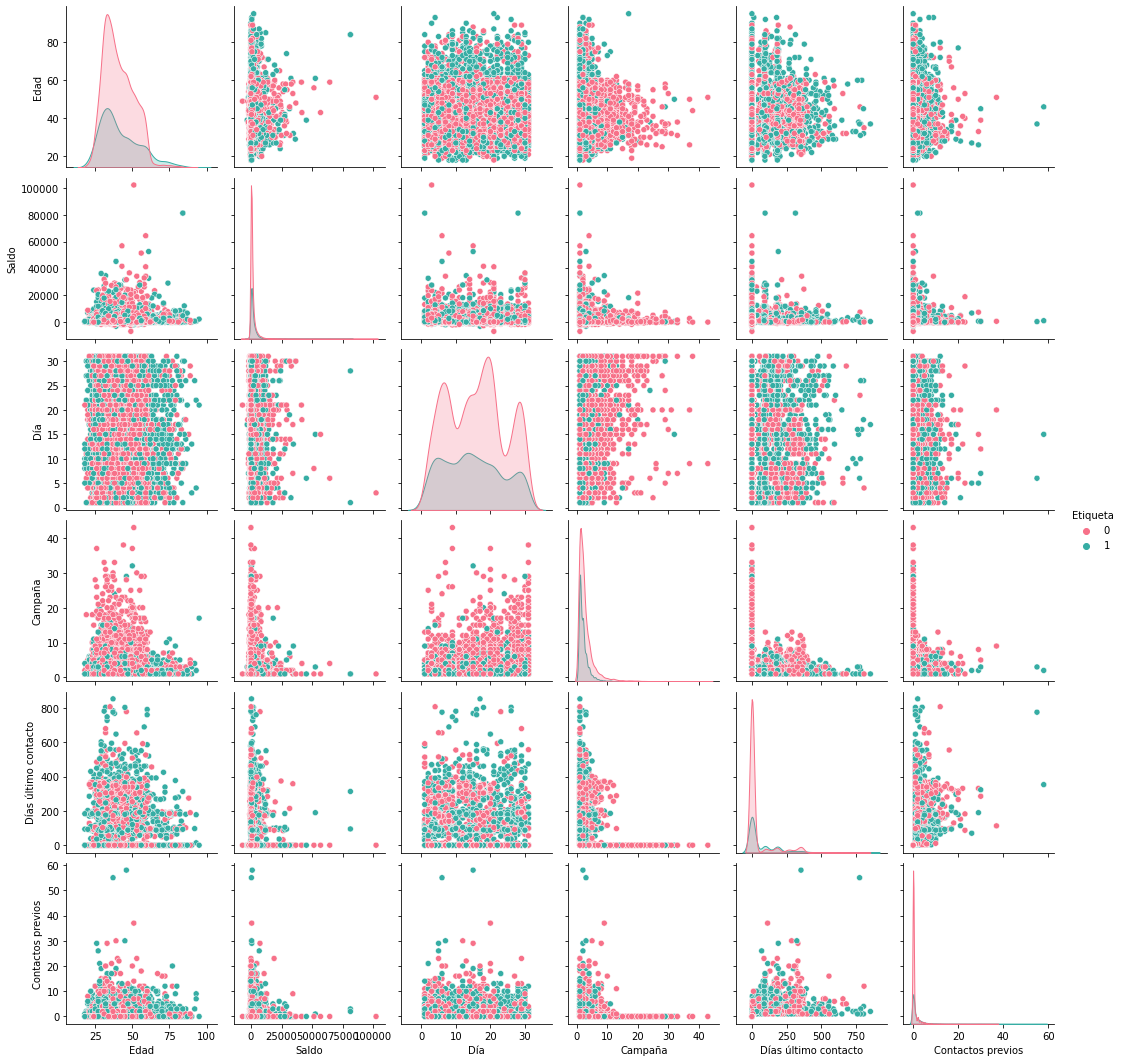

In [83]:
sns.pairplot(df, hue="Etiqueta", palette="husl")
plt.show()

# Funciones auxiliares

In [70]:
def train_val_test_split(df, rstate=42, shuffle=True, stratify=None):
    strat = df[stratify] if stratify else None
    train_set, test_set = train_test_split(
        df, test_size=0.4, random_state=rstate, shuffle=shuffle, stratify=strat)
    strat = test_set[stratify] if stratify else None
    val_set, test_set = train_test_split(
        test_set, test_size=0.5, random_state=rstate, shuffle=shuffle, stratify=strat)
    return (train_set, val_set, test_set)

def remove_labels(df, label_name):
    X = df.drop(label_name, axis=1)
    y = df[label_name].copy()
    return (X, y)

def evaluate_result(y_pred, y, y_prep_pred, y_prep, metric):
    print(metric.__name__, "Para datos de train:", metric(y_pred, y, average='weighted'))
    print(metric.__name__, "Para datos de validacion:", metric(y_prep_pred, y_prep, average='weighted'))

In [71]:
train_set, val_set, test_set = train_val_test_split(df, stratify="Etiqueta")

In [72]:
X_train, y_train = remove_labels(train_set, 'Etiqueta')
X_val, y_val = remove_labels(val_set, 'Etiqueta')
X_test, y_test = remove_labels(test_set, 'Etiqueta')

In [73]:
print("Longitud del Training Set:", len(train_set))
print("Longitud del Validation Set:", len(val_set))
print("Longitud del Test Set:", len(test_set))

Longitud del Training Set: 7674
Longitud del Validation Set: 2558
Longitud del Test Set: 2558


# Preprocesamiento

## Dummificacion

In [75]:
# Transormador para codificar únicamente las columnas categoricas y devolver un DataFrame
class CustomOneHotEncoding(BaseEstimator, TransformerMixin):
    def __init__(self):
        self._oh = OneHotEncoder(sparse=False)
        self._columns = None
    def fit(self, X, y=None):
        X_cat = X.select_dtypes(include=['object'])
        self._columns = pd.get_dummies(X_cat).columns
        self._oh.fit(X_cat)
        return self
    def transform(self, X, y=None):
        X_copy = X.copy()
        X_cat = X_copy.select_dtypes(include=['object'])
        X_num = X_copy.select_dtypes(exclude=['object'])
        X_cat_oh = self._oh.transform(X_cat)
        X_cat_oh = pd.DataFrame(X_cat_oh, 
                                columns=self._columns, 
                                index=X_copy.index)
        X_copy.drop(list(X_cat), axis=1, inplace=True)
        return X_copy.join(X_cat_oh)

In [76]:
# Crear una instancia del transformador
custom_encoding = CustomOneHotEncoding()

X_train_dum = custom_encoding.fit_transform(X_train)
X_val_dum = custom_encoding.fit_transform(X_val)
X_test_dum = custom_encoding.fit_transform(X_test)

## Escalado

In [77]:
class CustomScaler(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        self.robust_scaler = RobustScaler()
        self.robust_scaler.fit(X)
        return self
    
    def transform(self, X, y=None):
        X_scaled = self.robust_scaler.transform(X)
        X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)
        return X_scaled_df

In [78]:
custom_scaler = CustomScaler()

X_train_pro = custom_scaler.fit_transform(X_train_dum)
X_val_pro = custom_scaler.transform(X_val_dum)
X_test_pro = custom_scaler.transform(X_test_dum)

In [86]:
X_train_pro.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7674 entries, 6447 to 8819
Data columns (total 43 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Edad                        7674 non-null   float64
 1   Saldo                       7674 non-null   float64
 2   Día                         7674 non-null   float64
 3   Campaña                     7674 non-null   float64
 4   Días último contacto        7674 non-null   float64
 5   Contactos previos           7674 non-null   float64
 6   Ocupación_admin.            7674 non-null   float64
 7   Ocupación_blue-collar       7674 non-null   float64
 8   Ocupación_entrepreneur      7674 non-null   float64
 9   Ocupación_housemaid         7674 non-null   float64
 10  Ocupación_management        7674 non-null   float64
 11  Ocupación_retired           7674 non-null   float64
 12  Ocupación_self-employed     7674 non-null   float64
 13  Ocupación_services          76

# Modelo

In [119]:
y_train = y_train.astype(np.float32)
y_val = y_val.astype(np.float32)

In [157]:
model = models.Sequential()

model.add(layers.Dense(256, activation='relu', input_shape=(X_train_pro.shape[1],)))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(56, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

optimizer = keras.optimizers.Adam(learning_rate=0.0001)

model.compile(optimizer=optimizer,
             loss='binary_crossentropy',
             metrics=['accuracy', 'Precision'])

In [158]:
history1 = model.fit(X_train_pro,
                   y_train,
                   epochs=30,
                   batch_size=16,
                   validation_data=(X_val_pro, y_val))

Epoch 1/30
480/480 [==============================] - 2s 3ms/step - loss: 0.6151 - accuracy: 0.6999 - precision: 0.5363 - val_loss: 0.5893 - val_accuracy: 0.6970 - val_precision: 0.5132
Epoch 2/30
480/480 [==============================] - 1s 2ms/step - loss: 0.5702 - accuracy: 0.7197 - precision: 0.6081 - val_loss: 0.5436 - val_accuracy: 0.7412 - val_precision: 0.6460
Epoch 3/30
480/480 [==============================] - 1s 2ms/step - loss: 0.5492 - accuracy: 0.7370 - precision: 0.6317 - val_loss: 0.5356 - val_accuracy: 0.7424 - val_precision: 0.6720
Epoch 4/30
480/480 [==============================] - 1s 2ms/step - loss: 0.5417 - accuracy: 0.7443 - precision: 0.6457 - val_loss: 0.5314 - val_accuracy: 0.7498 - val_precision: 0.6689
Epoch 5/30
480/480 [==============================] - 1s 2ms/step - loss: 0.5373 - accuracy: 0.7450 - precision: 0.6388 - val_loss: 0.5351 - val_accuracy: 0.7455 - val_precision: 0.6420
Epoch 6/30
480/480 [==============================] - 1s 2ms/step - lo

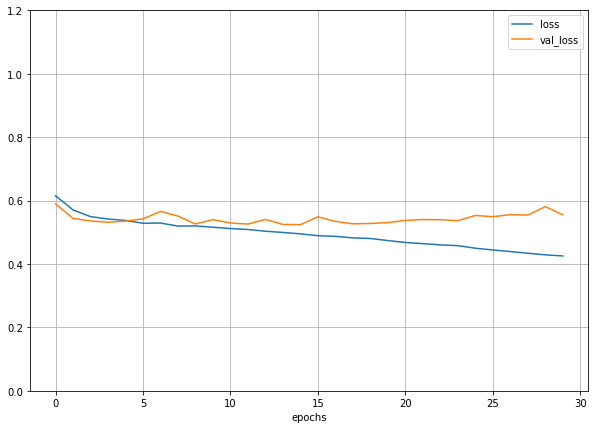

In [159]:
pd.DataFrame(history1.history)[['loss', 'val_loss']].plot(figsize=(10, 7))
plt.grid(True)
plt.gca().set_ylim(0, 1.2)
plt.xlabel("epochs")
plt.show()

# keras

In [160]:
from tensorflow.keras import models
from tensorflow.keras import layers

model = models.Sequential()

# Cambia la forma de entrada a (43,)
model.add(layers.Dense(256, activation='relu', input_shape=(43,)))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1, activation='sigmoid'))

In [161]:
optimizer = keras.optimizers.Adam(learning_rate=0.0001)

model.compile(
    optimizer=optimizer, 
    loss='binary_crossentropy',
    metrics=['accuracy', 'Precision']
)

In [162]:
history = model.fit(
    X_train_pro,
    y_train,
    epochs=20,
    batch_size=16,
    validation_data=(X_val_pro, y_val))

Epoch 1/20
480/480 [==============================] - 3s 4ms/step - loss: 0.9521 - accuracy: 0.6888 - precision: 0.4850 - val_loss: 0.5860 - val_accuracy: 0.6955 - val_precision: 0.9167
Epoch 2/20
480/480 [==============================] - 1s 3ms/step - loss: 0.7193 - accuracy: 0.6977 - precision: 0.5294 - val_loss: 0.5924 - val_accuracy: 0.6959 - val_precision: 0.5105
Epoch 3/20
480/480 [==============================] - 1s 2ms/step - loss: 0.6672 - accuracy: 0.6983 - precision: 0.5331 - val_loss: 0.5651 - val_accuracy: 0.6970 - val_precision: 0.5133
Epoch 4/20
480/480 [==============================] - 1s 3ms/step - loss: 0.6324 - accuracy: 0.6935 - precision: 0.5082 - val_loss: 0.5579 - val_accuracy: 0.6978 - val_precision: 0.5148
Epoch 5/20
480/480 [==============================] - 1s 3ms/step - loss: 0.6113 - accuracy: 0.6985 - precision: 0.5316 - val_loss: 0.5524 - val_accuracy: 0.7084 - val_precision: 0.7129
Epoch 6/20
480/480 [==============================] - 1s 3ms/step - lo

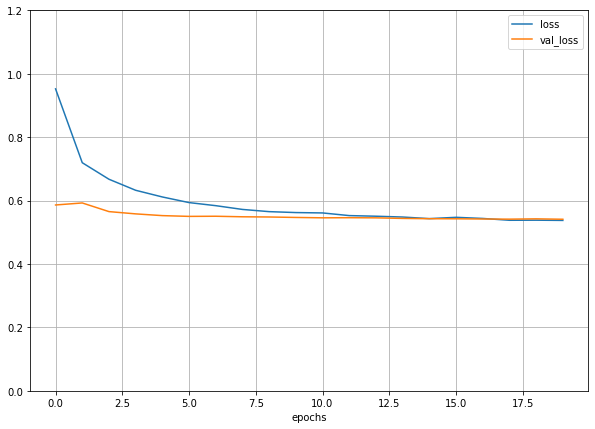

In [163]:
pd.DataFrame(history.history)[['loss', 'val_loss']].plot(figsize=(10, 7))
plt.grid(True)
plt.gca().set_ylim(0, 1.2)
plt.xlabel("epochs")
plt.show()

In [171]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

# Modelo entrenado con el conjunto de datos sin escalar
clf_rnd = RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1)
clf_rnd.fit(X_train_pro, y_train)

RandomForestClassifier(n_estimators=300, n_jobs=-1, random_state=42)

In [ ]:
y_train_pred = clf_rnd.predict(X_train)